# Plagiarism Detection Model

Now that you've created training and test data, you are ready to define and train a model. Your goal in this notebook, will be to train a binary classification model that learns to label an answer file as either plagiarized or not, based on the features you provide the model.

This task will be broken down into a few discrete steps:

* Upload your data to S3.
* Define a binary classification model and a training script.
* Train your model and deploy it.
* Evaluate your deployed classifier and answer some questions about your approach.

To complete this notebook, you'll have to complete all given exercises and answer all the questions in this notebook.
> All your tasks will be clearly labeled **EXERCISE** and questions as **QUESTION**.

It will be up to you to explore different classification models and decide on a model that gives you the best performance for this dataset.

---

## Load Data to S3

In the last notebook, you should have created two files: a `training.csv` and `test.csv` file with the features and class labels for the given corpus of plagiarized/non-plagiarized text data. 

>The below cells load in some AWS SageMaker libraries and creates a default bucket. After creating this bucket, you can upload your locally stored data to S3.

Save your train and test `.csv` feature files, locally. To do this you can run the second notebook "2_Plagiarism_Feature_Engineering" in SageMaker or you can manually upload your files to this notebook using the upload icon in Jupyter Lab. Then you can upload local files to S3 by using `sagemaker_session.upload_data` and pointing directly to where the training data is saved.

In [14]:
import pandas as pd
import boto3
import sagemaker
import numpy as np

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

## EXERCISE: Upload your training data to S3

Specify the `data_dir` where you've saved your `train.csv` file. Decide on a descriptive `prefix` that defines where your data will be uploaded in the default S3 bucket. Finally, create a pointer to your training data by calling `sagemaker_session.upload_data` and passing in the required parameters. It may help to look at the [Session documentation](https://sagemaker.readthedocs.io/en/stable/session.html#sagemaker.session.Session.upload_data) or previous SageMaker code examples.

You are expected to upload your entire directory. Later, the training script will only access the `train.csv` file.

In [16]:
# should be the name of directory you created to save your features data
data_dir = 'plagiarism_data'

# set prefix, a descriptive name for a directory  
prefix = 'plagiarism-detection'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

### Test cell

Test that your data has been successfully uploaded. The below cell prints out the items in your S3 bucket and will throw an error if it is empty. You should see the contents of your `data_dir` and perhaps some checkpoints. If you see any other files listed, then you may have some old model files that you can delete via the S3 console (though, additional files shouldn't affect the performance of model developed in this notebook).

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

plagiarism-detection/.ipynb_checkpoints/test-checkpoint.csv
plagiarism-detection/.ipynb_checkpoints/train-checkpoint.csv
plagiarism-detection/pytorch-training-2021-05-23-04-16-40-209/profiler-output/system/incremental/2021052304/1621743540.algo-1.json
plagiarism-detection/pytorch-training-2021-05-23-05-15-00-911/profiler-output/system/incremental/2021052305/1621747020.algo-1.json
plagiarism-detection/pytorch-training-2021-05-23-05-15-00-911/profiler-output/system/incremental/2021052305/1621747080.algo-1.json
plagiarism-detection/pytorch-training-2021-05-23-05-24-37-747/profiler-output/system/incremental/2021052305/1621747620.algo-1.json
plagiarism-detection/pytorch-training-2021-05-23-05-24-37-747/profiler-output/system/incremental/2021052305/1621747680.algo-1.json
plagiarism-detection/pytorch-training-2021-05-23-05-33-19-687/profiler-output/system/incremental/2021052305/1621748100.algo-1.json
plagiarism-detection/pytorch-training-2021-05-23-05-33-19-687/profiler-output/system/incremen

---

# Modeling

Now that you've uploaded your training data, it's time to define and train a model!

The type of model you create is up to you. For a binary classification task, you can choose to go one of three routes:
* Use a built-in classification algorithm, like LinearLearner.
* Define a custom Scikit-learn classifier, a comparison of models can be found [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).
* Define a custom PyTorch neural network classifier. 

It will be up to you to test out a variety of models and choose the best one. Your project will be graded on the accuracy of your final model. 
 
---

## EXERCISE: Complete a training script 

To implement a custom classifier, you'll need to complete a `train.py` script. You've been given the folders `source_sklearn` and `source_pytorch` which hold starting code for a custom Scikit-learn model and a PyTorch model, respectively. Each directory has a `train.py` training script. To complete this project **you only need to complete one of these scripts**; the script that is responsible for training your final model.

A typical training script:
* Loads training data from a specified directory
* Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
* Instantiates a model of your design, with any specified hyperparams
* Trains that model 
* Finally, saves the model so that it can be hosted/deployed, later

### Defining and training a model
Much of the training script code is provided for you. Almost all of your work will be done in the `if __name__ == '__main__':` section. To complete a `train.py` file, you will:
1. Import any extra libraries you need
2. Define any additional model training hyperparameters using `parser.add_argument`
2. Define a model in the `if __name__ == '__main__':` section
3. Train the model in that same section

Below, you can use `!pygmentize` to display an existing `train.py` file. Read through the code; all of your tasks are marked with `TODO` comments. 

**Note: If you choose to create a custom PyTorch model, you will be responsible for defining the model in the `model.py` file,** and a `predict.py` file is provided. If you choose to use Scikit-learn, you only need a `train.py` file; you may import a classifier from the `sklearn` library.

In [18]:
# directory can be changed to: source_sklearn or source_pytorch
!pygmentize source_pytorch/train.py

import argparse
import json
import os
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data

# imports the model in model.py by name
from model import BinaryClassifier

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BinaryClassifier(model_info['input_features'], model_info['hidden_dim'], model_info['output_dim'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
        model.load_state_dict(torch.load(

### Provided code

If you read the code above, you can see that the starter code includes a few things:
* Model loading (`model_fn`) and saving code
* Getting SageMaker's default hyperparameters
* Loading the training data by name, `train.csv` and extracting the features and labels, `train_x`, and `train_y`

If you'd like to read more about model saving with [joblib for sklearn](https://scikit-learn.org/stable/modules/model_persistence.html) or with [torch.save](https://pytorch.org/tutorials/beginner/saving_loading_models.html), click on the provided links.

---
# Create an Estimator

When a custom model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained; the `train.py` function you specified above. To run a custom training script in SageMaker, construct an estimator, and fill in the appropriate constructor arguments:

* **entry_point**: The path to the Python script SageMaker runs for training and prediction.
* **source_dir**: The path to the training script directory `source_sklearn` OR `source_pytorch`.
* **role**: Role ARN, which was specified, above.
* **train_instance_count**: The number of training instances (should be left at 1).
* **train_instance_type**: The type of SageMaker instance for training. Note: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* **sagemaker_session**: The session used to train on Sagemaker.
* **hyperparameters** (optional): A dictionary `{'name':value, ..}` passed to the train function as hyperparameters.

Note: For a PyTorch model, there is another optional argument **framework_version**, which you can set to the latest version of PyTorch, `1.0`.

## EXERCISE: Define a Scikit-learn or PyTorch estimator

To import your desired estimator, use one of the following lines:
```
from sagemaker.sklearn.estimator import SKLearn
```
```
from sagemaker.pytorch import PyTorch
```

In [19]:
# Define global values for the model
INPUT_FEATURES = 4 # number of input features saved in the previous notebook
HIDDEN_DIMENSION = 20 # Hidden layer dimension
OUTPUT_DIMENSION = 1 # Estimator uutput dimension
LEARNING_RATE = 0.001
EPOCHS = 100 # Epochs for training
SOURCE_DIR = 'source_pytorch'
OUTPUT_PATH = 's3://{}/{}'.format(bucket, prefix) # Model output path to write results

In [20]:
# your import and estimator code, here
from sagemaker.pytorch import PyTorch

pytorch_estimator = PyTorch(entry_point='train.py',
                    source_dir= SOURCE_DIR,
                    role=role,
                    framework_version='1.0', 
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.m4.xlarge',
                    output_path=OUTPUT_PATH,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': EPOCHS,
                        'lr': LEARNING_RATE,
                        'input_features': INPUT_FEATURES,
                        'hidden_dim': HIDDEN_DIMENSION,
                        'output_dim': OUTPUT_DIMENSION,
                    })

## EXERCISE: Train the estimator

Train your estimator on the training data stored in S3. This should create a training job that you can monitor in your SageMaker console.

In [21]:
%%time

# Train your estimator on S3 training data
pytorch_estimator.fit({'train': input_data})

2021-05-25 01:02:38 Starting - Starting the training job...
2021-05-25 01:02:48 Starting - Launching requested ML instancesProfilerReport-1621904558: InProgress
.........
2021-05-25 01:04:40 Starting - Preparing the instances for training......
2021-05-25 01:05:40 Downloading - Downloading input data...
2021-05-25 01:06:02 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-05-25 01:06:25,318 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-05-25 01:06:25,321 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-25 01:06:25,337 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

2021-05-25 01:06:40 Training - Training image download completed. Training in progress.2021-05-25 01:06:28,352 sagemaker_pytorch_container.training INFO     Invoking user training script.

2021-05

## ADDITIONAL STEP: Model optimization

## EXERCISE: Deploy the trained model

After training, deploy your model to create a `predictor`. If you're using a PyTorch model, you'll need to create a trained `PyTorchModel` that accepts the trained `<model>.model_data` as an input parameter and points to the provided `source_pytorch/predict.py` file as an entry point. 

To deploy a trained model, you'll use `<model>.deploy`, which takes in two arguments:
* **initial_instance_count**: The number of deployed instances (1).
* **instance_type**: The type of SageMaker instance for deployment.

Note: If you run into an instance error, it may be because you chose the wrong training or deployment instance_type. It may help to refer to your previous exercise code to see which types of instances we used.

In [22]:
%%time

# uncomment, if needed
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(model_data=pytorch_estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     py_version='py3',
                     entry_point='predict.py',
                     source_dir=SOURCE_DIR)

# deploy your model to create a predictor
predictor = pytorch_model.deploy(instance_type='ml.m4.xlarge',initial_instance_count=1)

---------------!CPU times: user 352 ms, sys: 17.5 ms, total: 369 ms
Wall time: 7min 32s


---
# Evaluating Your Model

Once your model is deployed, you can see how it performs when applied to our test data.

The provided cell below, reads in the test data, assuming it is stored locally in `data_dir` and named `test.csv`. The labels and features are extracted from the `.csv` file.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import os

# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)

# labels are in the first column
test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

In [24]:
print(test_x)

           1         2         3         4
0   1.000000  0.984694  0.964103  0.820755
1   0.765306  0.709898  0.664384  0.621711
2   0.884444  0.526786  0.340807  0.597458
3   0.619048  0.250000  0.112299  0.427835
4   0.920000  0.675676  0.561644  0.775000
5   0.992674  0.985294  0.981550  0.993056
6   0.412698  0.112903  0.032787  0.346667
7   0.462687  0.070000  0.010050  0.189320
8   0.581152  0.142105  0.037037  0.247423
9   0.584211  0.142857  0.010638  0.294416
10  0.566372  0.151786  0.036036  0.258333
11  0.481481  0.171642  0.067669  0.278912
12  0.619792  0.251309  0.100000  0.341584
13  0.921739  0.842795  0.776316  0.929412
14  1.000000  0.980843  0.961538  1.000000
15  0.861538  0.396907  0.181347  0.504717
16  0.626168  0.465625  0.363636  0.558559
17  1.000000  0.992308  0.984556  0.996700
18  0.383838  0.076142  0.025510  0.178744
19  1.000000  0.989051  0.974359  0.854671
20  0.613924  0.133758  0.019231  0.298343
21  0.972763  0.937500  0.901961  0.927083
22  0.96281

## EXERCISE: Determine the accuracy of your model

Use your deployed `predictor` to generate predicted, class labels for the test data. Compare those to the *true* labels, `test_y`, and calculate the accuracy as a value between 0 and 1.0 that indicates the fraction of test data that your model classified correctly. You may use [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for this calculation.

**To pass this project, your model should get at least 90% test accuracy.**

In [25]:
# First: generate predicted, class labels
test_y_preds = predictor.predict(test_x)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# test that your model generates the correct number of labels
assert len(test_y_preds)==len(test_y), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [45]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

# Second: calculate the test accuracy
accuracy = accuracy_score(test_y,test_y_preds)

print("Accuracy: ",accuracy)

## print out the array of predicted and true labels, if you want
print('\nPredicted class labels: ')
print(test_y_preds[:].tolist())
print('\nTrue class labels: ')
print(test_y.values)

Accuracy:  1.0

Predicted class labels: 
[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0]]

True class labels: 
[1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0]


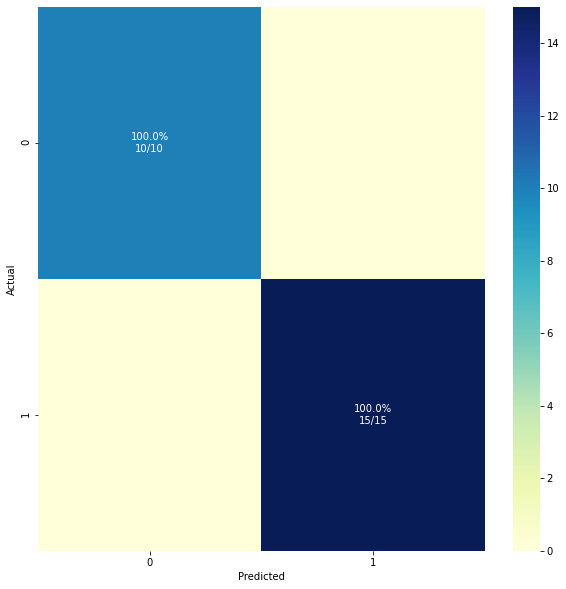

In [33]:
# Plot confusion matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(test_y, test_y_preds)

### Question 1: How many false positives and false negatives did your model produce, if any? And why do you think this is?

**Answer**: 

Models perform "Perfect" 100% True positives and 100% True Negatives. The model looks overfitted because data is small and the model complexity is high (3 layers fully connected Neuronal Network). Maybe the option to use Pytorch was not the best in terms of the problem definition but was a nice implementation.

### Question 2: How did you decide on the type of model to use? 

**Answer** :

I think due to the data amount and feature number, a simple model may have been enough to perform binary classification. But I wanted to explore the Pytorch implementation considering also that a Neural Network can perform well for a binary classification problem.

----
## EXERCISE: Clean up Resources

After you're done evaluating your model, **delete your model endpoint**. You can do this with a call to `.delete_endpoint()`. You need to show, in this notebook, that the endpoint was deleted. Any other resources, you may delete from the AWS console, and you will find more instructions on cleaning up all your resources, below.

In [46]:
# uncomment and fill in the line below!
# <name_of_deployed_predictor>.delete_endpoint()
predictor.delete_endpoint()

### Deleting S3 bucket

When you are *completely* done with training and testing models, you can also delete your entire S3 bucket. If you do this before you are done training your model, you'll have to recreate your S3 bucket and upload your training data again.

In [47]:
# deleting bucket, uncomment lines below

bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': 'YTEDXNG9EF3V372A',
   'HostId': 'tqeQaicsPGhPlSvEp/CuH0uelMi4nJkx/g1iLIbJmH2sD/qJOTEqs/+e6H+m4TNxYjerpWDem4g=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'tqeQaicsPGhPlSvEp/CuH0uelMi4nJkx/g1iLIbJmH2sD/qJOTEqs/+e6H+m4TNxYjerpWDem4g=',
    'x-amz-request-id': 'YTEDXNG9EF3V372A',
    'date': 'Tue, 25 May 2021 01:49:46 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'plagiarism-detection/sagemaker-pytorch-2021-05-24-01-10-33-439/rule-output/ProfilerReport-1621818633/profiler-output/profiler-reports/OverallSystemUsage.json'},
   {'Key': 'plagiarism-detection/sagemaker-pytorch-210523-0852-015-0f852d78/output/model.tar.gz'},
   {'Key': 'sagemaker-pytorch-2021-05-23-18-20-36-350/source/sourcedir.tar.gz'},
   {'Key': 'plagiarism-detection/sagemaker-pytorch-2021-05-25-01-02-38-454/output/model.tar.gz'},
   {'Key

### Deleting all your models and instances

When you are _completely_ done with this project and do **not** ever want to revisit this notebook, you can choose to delete all of your SageMaker notebook instances and models by following [these instructions](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html). Before you delete this notebook instance, I recommend at least downloading a copy and saving it, locally.

---
## Further Directions

There are many ways to improve or add on to this project to expand your learning or make this more of a unique project for you. A few ideas are listed below:
* Train a classifier to predict the *category* (1-3) of plagiarism and not just plagiarized (1) or not (0).
* Utilize a different and larger dataset to see if this model can be extended to other types of plagiarism.
* Use language or character-level analysis to find different (and more) similarity features.
* Write a complete pipeline function that accepts a source text and submitted text file, and classifies the submitted text as plagiarized or not.
* Use API Gateway and a lambda function to deploy your model to a web application.

These are all just options for extending your work. If you've completed all the exercises in this notebook, you've completed a real-world application, and can proceed to submit your project. Great job!